In [27]:
import catboost
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import xgboost as xgb

from catboost import Pool, CatBoostRegressor, cv
from itertools import product, chain
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.pylab import rcParams
from mlxtend.preprocessing import DenseTransformer

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, LabelEncoder

from paramsearch import paramsearch
import util
reload(util)
from util import plot_top_features, crossvaltest, catboost_param_tune

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 


# matplotlib settings
matplotlib.style.use('ggplot')
rcParams['figure.figsize'] = 12, 8
rcParams['font.size'] = 12
rcParams['axes.facecolor'] = 'white'

In [2]:
# ! pip install jupyternotify
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [3]:
n_time = 3
n_folds = 5

# Data Loading

In [4]:
df_train = pd.read_csv('../data/housing_usa/train.csv')
df_train.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [5]:
y_train = np.log1p(df_train['SalePrice'])
df_train = df_train.drop('SalePrice', axis = 1)

In [6]:
cat_features = list(df_train.select_dtypes(include=['object']).columns.values)
cat_indices = [df_train.columns.get_loc(name) for name in cat_features]

df_train[cat_features] = df_train[cat_features].astype(str)

In [7]:
pool_train = Pool(df_train, label = y_train, cat_features=cat_indices)

## Exploratory Data Analysis
### Data statistics

In [8]:
print ("number of training instances = {0}".format(df_train.shape[0]))
print ("number of features = {0}".format(df_train.shape[1]))
print ("number of categorical features = {0}".format(len(cat_indices)))

number of training instances = 1460
number of features = 80
number of categorical features = 43


#### Price distribution (log scale)

In [9]:
print("mean = {0}, std_dev = {1}".format(np.mean(y_train), np.std(y_train)))

mean = 12.0240573949, std_dev = 0.399312452194


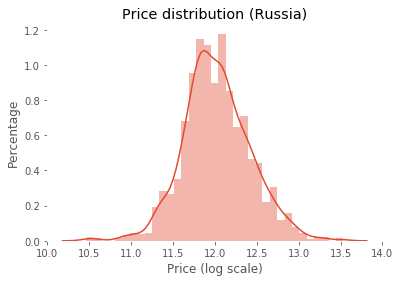

In [10]:
sns.distplot(y_train, norm_hist=True)
plt.xlabel('Price (log scale)')
plt.ylabel('Percentage')
plt.title('Price distribution (Russia)')
plt.show()

# CatBoost

In [28]:
model = CatBoostRegressor(loss_function = 'RMSE', custom_metric = 'RMSE',  calc_feature_importance = True)

cv_params = model.get_params()
del cv_params['calc_feature_importance']

In [ ]:
%%notify
av_time = 0
for i in range(0, n_time):
    t = time.time()
    cv_data = crossvaltest(cv_params, df_train, y_train, cat_indices, n_folds)
    av_time += time.time() - t

In [ ]:
model.fit(pool_train, logging_level='Silent')

In [ ]:
print('average cv time (CatBoost) = {0:.2f}'.format(av_time / n_time))
print('RMSLE (CatBoost) = {0}'.format(-cv_data)) 

In [ ]:
top_features = plot_top_features(model, pool_train.get_feature_names(), 20)

In [ ]:
cat_grid_params = {
    'depth': [1, 2, 3],
    'learning_rate': [0.1, 0.05, 0.01],
    'iterations' : [100, 500, 1000]
}
best_params = catboost_param_tune(cat_grid_params, df_train, y_train, cat_indices, 5)

In [ ]:
best_params['loss_function'] = 'RMSE'
best_params['custom_metric'] = 'RMSE'
best_params['calc_feature_importance'] = True

### Tuned (with best params)

In [25]:
%%notify
model = CatBoostRegressor(**best_params)
cv_params = model.get_params()
del cv_params['calc_feature_importance']


av_time = 0
for i in range(0, n_time):
    t = time.time()
    cv_data = crossvaltest(cv_params, df_train, y_train, cat_indices, n_folds)
    av_time += time.time() - t

<IPython.core.display.Javascript object>

In [26]:
print('average cv time (CatBoost) = {0:.2f}'.format(av_time / n_time))
print('RMSLE (CatBoost) = {0}'.format(cv_data)) 

average cv time (CatBoost) = 13.61
RMSLE (CatBoost) = 19.8039959251


# XGBoost

In [ ]:
df_train_dummy = pd.get_dummies(df_train, columns = cat_features)

### Default version

In [ ]:
xgboost_clf = Pipeline([('to_dense', DenseTransformer()), 
                        ('clf', xgb.XGBRegressor(eval_metric = 'rmse'))])
_ = xgboost_clf.fit(df_train_dummy, y_train)

av_time = 0
for i in range(0, n_time):
    t = time.time()
    xgboost_cv = cross_val_score(xgboost_clf, df_train_dummy, y_train, 
                             scoring='neg_mean_squared_error', cv=n_folds, n_jobs = -1, verbose=False)
    av_time += time.time() - t

In [ ]:
print('average cv time (XGBoost) = {0:.2f} sec'.format(av_time / n_time))
print('RMSLE (XGBoost) = {0}'.format(np.sqrt(-xgboost_cv.mean())))

In [ ]:
_ = plot_top_features(xgboost_clf.named_steps['clf'], df_train_dummy.columns.values, 20)

In [ ]:
grid_params = {
    'clf__max_depth': [1, 2, 3],
    'clf__learning_rate': [0.1, 0.05, 0.01],
    'clf__n_estimators' : [100, 500, 1000]
}

In [ ]:
grid_search_xgb = GridSearchCV(xgboost_clf, grid_params, scoring='neg_mean_squared_error', 
                               cv=n_folds, verbose=False)
_ = grid_search_xgb.fit(df_train_dummy, y_train)

In [ ]:
best_parameters_xgb = max(grid_search_xgb.grid_scores_, key=lambda x: x[1])[0]
best_parameters_xgb

### Tuned version (with the best parameters found with grid search)

In [ ]:
xgboost_clf = Pipeline([('to_dense', DenseTransformer()), 
                        ('clf', xgb.XGBRegressor(eval_metric = 'rmse', 
                                                 learning_rate = best_parameters_xgb['clf__learning_rate'], 
                                                 n_estimators = best_parameters_xgb['clf__n_estimators'],
                                                 max_depth = best_parameters_xgb['clf__max_depth']))])

In [ ]:
av_time = 0
for i in range(0, n_time):
    t = time.time()
    xgboost_cv = cross_val_score(xgboost_clf, df_train_dummy, y_train, 
                             scoring='neg_mean_squared_error', cv=n_folds, n_jobs = -1, verbose=False)
    av_time += time.time() - t

In [ ]:
print('average cv time (XGBoost) = {0:.2f} sec'.format(av_time / n_time))
print('RMSLE (XGBoost) = {0}'.format(np.sqrt(-xgboost_cv.mean())))

# GradientBoostingRegressor

In [ ]:
sk_boost_clf = Pipeline([('replace_nan', Imputer()),
                        ('to_dense', DenseTransformer()), 
                        ('clf', GradientBoostingRegressor())])

In [ ]:
_ = sk_boost_clf.fit(df_train_dummy, y_train)

In [ ]:
av_time = 0
for i in range(0, n_time):
    t = time.time()
    sklearn_cv = cross_val_score(sk_boost_clf, df_train_dummy, y_train, 
                     scoring='neg_mean_squared_error', cv=n_folds, n_jobs = -1, verbose=False)
    av_time += time.time() - t

In [ ]:
print('average cv time (GradientBoostingRegressor) = {0:.2f} sec'.format(av_time / n_time))
print('RMSLE (GradientBoostingRegressor) = {0}'.format(np.sqrt(-sklearn_cv.mean())))

In [ ]:
_ = plot_top_features(sk_boost_clf.named_steps['clf'], df_train_dummy.columns.values, 20)

In [ ]:
grid_search_sk = GridSearchCV(sk_boost_clf, grid_params, scoring='neg_mean_squared_error', 
                               cv=n_folds, verbose=True)
_ = grid_search_sk.fit(df_train_dummy, y_train)

In [ ]:
best_parameters_sk = max(grid_search_sk.grid_scores_, key=lambda x: x[1])[0]
best_parameters_sk

### Tuned version (with the best parameters found with grid search)

In [ ]:
sk_boost_clf = Pipeline([('replace_nan', Imputer()),
                        ('to_dense', DenseTransformer()), 
                        ('clf', GradientBoostingRegressor(learning_rate = best_parameters_sk['clf__learning_rate'], 
                                                 n_estimators = best_parameters_sk['clf__n_estimators'],
                                                 max_depth = best_parameters_sk['clf__max_depth']))])

In [ ]:
av_time = 0
for i in range(0, n_time):
    t = time.time()
    sklearn_cv = cross_val_score(sk_boost_clf, df_train_dummy, y_train, 
                             scoring='neg_mean_squared_error', cv=n_folds, n_jobs = -1, verbose=False)
    av_time += time.time() - t

In [ ]:
print('average cv time (GradientBoostingRegressor) = {0:.2f} sec'.format(av_time / n_time))
print('RMSLE (GradientBoostingRegressor) = {0}'.format(np.sqrt(-sklearn_cv.mean())))